In [1]:
import gc
import numpy as np
import scipy.io
from scipy.ndimage import convolve
from scipy.signal import convolve2d
from skimage.color import rgb2gray
from scipy.ndimage import convolve, gaussian_filter
from numpy.fft import fft2, ifft2, fftshift

import scipy.io
from scipy import signal
import cv2
import numpy as np
from scipy.ndimage import zoom
from scipy.signal import convolve2d
from PIL import Image
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter, maximum_filter
from scipy.sparse import spdiags, eye
from scipy.sparse.linalg import spsolve
from skimage.color import rgb2gray
from sklearn.neighbors import KDTree
from scipy.signal import fftconvolve
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from sklearn.metrics import mean_squared_error

C:\Users\mehreen\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def mean_absolute_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Error between two arrays of values.

    Parameters:
    y_true (numpy array or list): Actual values
    y_pred (numpy array or list): Predicted values

    Returns:
    float: The Mean Absolute Error
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    if y_true.shape != y_pred.shape:
        raise ValueError("Input arrays must have the same shape.")
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

In [3]:
def gradient_weight(I):
    if len(I.shape) == 3 and I.shape[2] == 3:  # If the image has RGB channels
        I = np.dot(I[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale using standard weights

    lambda_val = 10
    f1 = np.array([[0, 0, 0],[1, -1, 0],[0, 0, 0]])
    f2 = np.array([[0, 1, 0],[0, -1, 0],[0, 0, 0]])
    
    Gx = signal.convolve2d(I, f1, mode='same')
    Gy = signal.convolve2d(I, f2, mode='same')

    ax = np.exp(-lambda_val * np.abs(Gx))
    thx = Gx < 0.01
    ax[thx] = 0
    weight_x = 1 + ax

    ay = np.exp(-lambda_val * np.abs(Gy))
    thy = Gy < 0.01
    ay[thy] = 0
    weight_y = 1 + ay

    return weight_x, weight_y

def psf2otf(psf, shape):
    psf = np.pad(psf, [(0, shape[0] - psf.shape[0]), (0, shape[1] - psf.shape[1])], mode='constant')
    for axis, axis_size in enumerate(psf.shape):
        psf = np.roll(psf, -axis_size // 2, axis=axis)
    otf = fft2(psf.T).T
    return otf

def convolve_rgb(image, kernel):
   
    border_size = 1
    foggy_image_with_border = cv2.copyMakeBorder(image, 
                                                 top=border_size, 
                                                 bottom=border_size, 
                                                 left=border_size, 
                                                 right=border_size, 
                                                 borderType=cv2.BORDER_WRAP)

    # Apply the filter
    temp = cv2.filter2D(foggy_image_with_border, -1, kernel)

    # Remove the added border
    temp = temp[border_size:-border_size, border_size:-border_size]
    print(temp.shape)

    return temp

In [4]:

def decomposition(I, alpha, ii, beta, gamma):
    alpha = float(alpha)
    ii = float(ii)
    beta = float(beta)
    gamma = float(gamma)
    I = np.clip(I, 0, 1)
    gray = np.mean(I, axis=2)
    H, W, D = I.shape

    weight_x, weight_y = gradient_weight(I)
    # f1 = np.array([[1, -1]])
    # f2 = np.array([[1], [-1]])
    f1 = np.array([[0, 0, 0],[1, -1, 0],[0, 0, 0]])
    f2 = np.array([[0, 1, 0],[0, -1, 0],[0, 0, 0]])
    f4 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

    gray = rgb2gray(I)
    I_filt = gaussian_filter(gray, sigma = 10)
    delta_I = I - I_filt[..., np.newaxis]

    otfFx = psf2otf(f1, (H, W))
    otfFy = psf2otf(f2, (H, W))
    otfL = psf2otf(f4, (H, W))

    fft_double_laplace = np.abs(otfL) ** 2
    fft_double_grad = np.abs(otfFx) ** 2 + np.abs(otfFy) ** 2

    if D > 1:
        fft_double_grad = np.repeat(fft_double_grad[:, :, np.newaxis], D, axis=2)
        fft_double_laplace = np.repeat(fft_double_laplace[:, :, np.newaxis], D, axis=2)
        weight_x = np.repeat(weight_x[:, :, np.newaxis], D, axis=2)
        weight_y = np.repeat(weight_y[:, :, np.newaxis], D, axis=2)

    F = np.zeros_like(I)
    N = np.zeros_like(I)
    gray = rgb2gray(I)

    Ix = np.zeros_like(I)
    Iy = np.zeros_like(I)

    for channel in range(I.shape[2]):
        Ix[:, :, channel] = signal.convolve2d(I[:, :, channel], f1,mode='same')
        Iy[:, :, channel] = signal.convolve2d(I[:, :, channel], f2,mode='same')


    Normin_I = fft2((np.concatenate((Ix[:, -1:, :] - Ix[:, :1, :], -np.diff(Ix, 1, 1)), axis=1) +
                   np.concatenate((Iy[-1:, :, :] - Iy[:1, :, :], -np.diff(Iy, 1, 0)), axis=0)).T).T
    Denormin_N = gamma + alpha * fft_double_laplace + beta
    Normin_gI = fft_double_laplace * fft2(I.T).T
    
    print(np.min(np.abs(Denormin_N)), np.max(np.abs(Denormin_N)), np.mean(np.abs(Denormin_N))) 
    print(np.min(np.abs(Normin_gI)), np.max(np.abs(Normin_gI)), np.mean(np.abs(Normin_gI))) 


    # return(F, I_filt, delta_I, fft_double_laplace, fft_double_grad, Normin_I, Denormin_N, Normin_gI)

    i = 0
    f1 = np.array([[1, -1]])
    f1 = np.array([[-1, 1]])
    while True:
        i += 1
        prev_F = F.copy()

        lambda_ = min(2 ** (ii + i), 10 ** 5)
        Denormin_F = lambda_ * fft_double_grad + alpha * fft_double_laplace + beta

        qx = np.zeros_like(I)
        qy = np.zeros_like(I)
        
        qx = -convolve_rgb(F, f1) - Ix
        qy = -convolve_rgb(F, f2) - Iy
#         for channel in range(I.shape[2]):
#             qx[:, :, channel] = signal.convolve2d(I[:, :, channel], f1,mode='same') - Ix[:,:,channel]
#             qy[:, :, channel] = signal.convolve2d(I[:, :, channel], f2,mode='same') - Iy[:,:,channel]

        qx = np.sign(qx) * np.maximum(np.abs(qx) - weight_x / lambda_, 0)
        qy = np.sign(qy) * np.maximum(np.abs(qy) - weight_y / lambda_, 0)

        Normin_q = np.concatenate((qx[:, -1:, :] - qx[:, :1, :], -np.diff(qx, 1, 1)), axis=1) + \
                    np.concatenate((qy[-1:, :, :] - qy[:1, :, :], -np.diff(qy, 1, 0)), axis=0)
        Normin_gN = fft_double_laplace * fft2(N.T).T

        FF = (lambda_ * (Normin_I + fft2(Normin_q.T).T) +
              alpha * (Normin_gI - Normin_gN) + beta * fft2((delta_I - N).T).T) / Denormin_F
        F = np.real(ifft2(FF.T).T)

        Normin_F = fft_double_laplace * fft2(F.T).T
        B = fft2((delta_I - F).T).T
        NN = (alpha * (Normin_gI - Normin_F) + beta * B) / Denormin_N
        N = np.real(ifft2(NN.T).T)
        print(np.sum(np.abs(prev_F - F)) / (H * W))
        if np.sum(np.abs(prev_F - F)) / (H * W) < 10 ** (-1):
            break
    for c in range(D):
        Ft = F[:, :, c]
        q = np.size(Ft)
        for k in range(500):
            m = np.sum(Ft[Ft < 0])
            n = np.sum(Ft[Ft > 1] - 1)
            dt = (m + n) / q
            if np.abs(dt) < 1 / q:
                break
            Ft = Ft - dt
        F[:, :, c] = Ft

    F = np.abs(F)
    F[F > 1] = 1

    N[N > 1] = 1
    N[N < 0] = 0
    N = np.mean(N, axis=2)

    G = np.abs(I - F - N[:, :, np.newaxis])
    G = np.min(G, axis=2)
    G = gaussian_filter(G, 3)

    F = np.abs(I - G[:, :, np.newaxis] - N[:, :, np.newaxis])
    F[F == 0] = 0.001

    return F, G, N

10.1 1280006.5634043636 400010.09999999974
0.0 2703.2192419024022 117.39582280295491
(650, 945, 3)
(650, 945, 3)
0.3071848706310551
(650, 945, 3)
(650, 945, 3)
0.033625717850426166


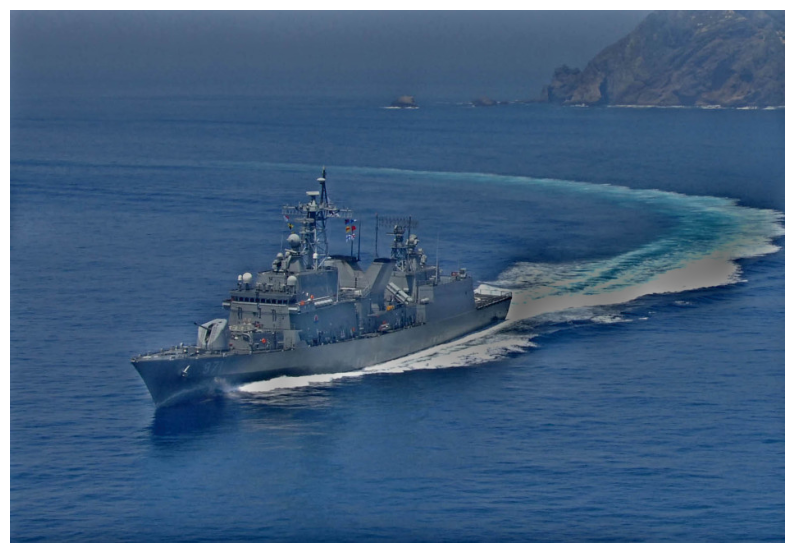

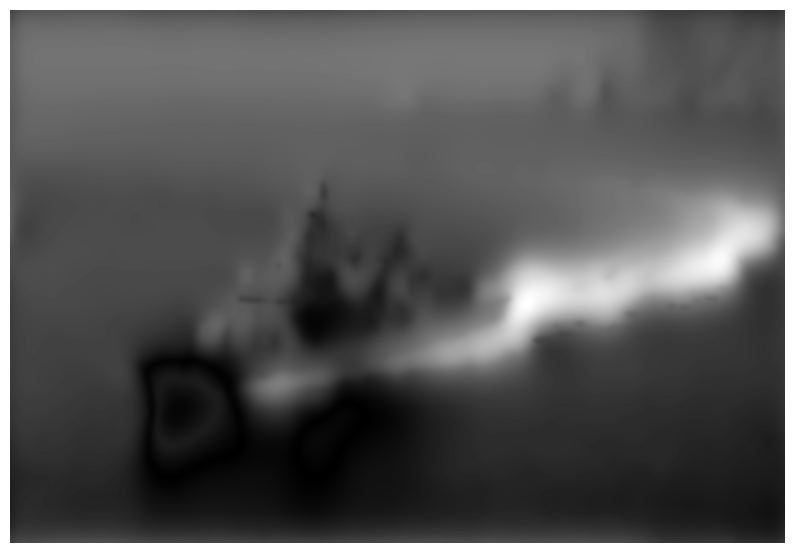

In [5]:
foggy_image_path = r'.\Test_Data\V_07_01_0019.jpg'

# Read the image using OpenCV
foggy_image = cv2.imread(foggy_image_path)

# Convert the image from BGR to RGB (OpenCV reads images in BGR format)
foggy_image = cv2.cvtColor(foggy_image, cv2.COLOR_BGR2RGB)

# Get the defogged image
# defogged_image, F, G = Defogging(foggy_image,air_light = [.12,.17,.26],ii=5)

# def Defogging(input_img,air_light = [],ii = 5):
ii = 5
adjust_fog_removal = 2
brightness = 2
input_img = foggy_image
# Convert image from uint8 to float32 (similar to im2double)
input_img = input_img.astype(np.float32) / input_img.max()
alpha = 20000
beta = 0.1
gamma = 10

F, G, _ = decomposition(input_img, alpha, ii, beta, gamma)
    
plt.figure(figsize=(10,10))
plt.imshow(F)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(G, 'gray')
plt.axis('off')
plt.show()

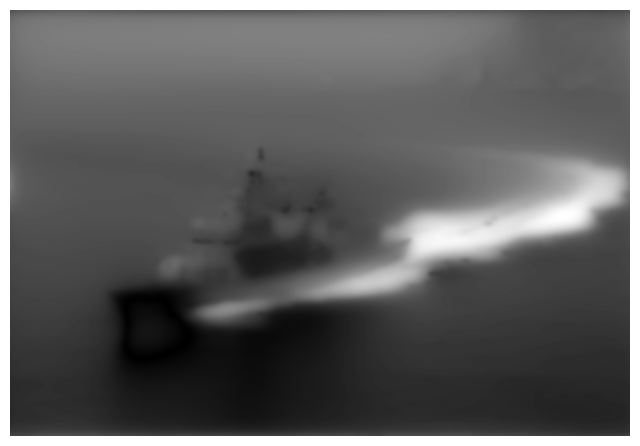

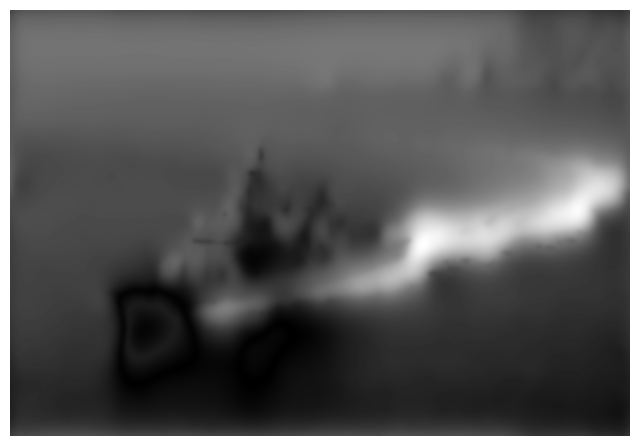

In [7]:
mat_contents = scipy.io.loadmat(r'.\mat_data_file\Decomposition.mat')
# transmission_estimation, data_term_weight, img_hazy, lambda  'fog_free_layer', 'F', 'A') .mat','I','gray','I_filt'
F_mat = mat_contents['F']
G_mat = mat_contents['G']
input_mat = mat_contents['input']

plt.figure(figsize=(8,8))
plt.imshow(G_mat, 'gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(G, 'gray')
plt.axis('off')
plt.show()


# ii = 7
# adjust_fog_removal = 2
# brightness = 2
# input_img = foggy_image
# # Convert image from uint8 to float32 (similar to im2double)
# # input_img = input_img.astype(np.float32) / input_img.max()
# alpha = 20000
# beta = 0.5
# gamma = 10

# F, G, _ = decomposition(input_mat, alpha, ii, beta, gamma)

# mean_absolute_error(F_mat, F), mean_absolute_error(G_mat, G)

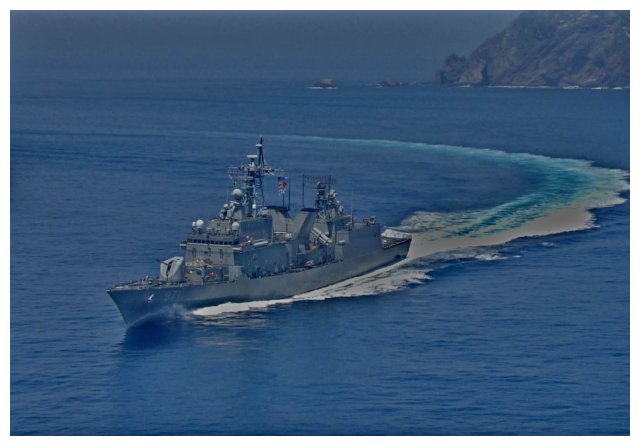

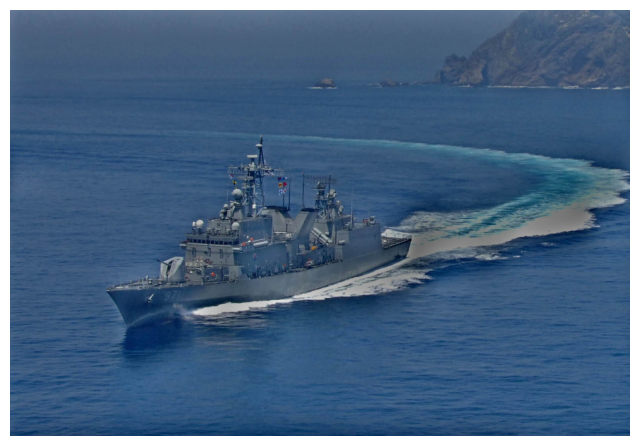

In [8]:

plt.figure(figsize=(8,8))
plt.imshow(F_mat)
plt.axis('off')
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(F)
plt.axis('off')
plt.show()